# Multi-bin Poisson

In [1]:
import logging
import json
import math
import numpy as np
import matplotlib.pyplot as plt

import pyhf
from pyhf import Model, optimizer
from pyhf.simplemodels import hepdata_like
from pyhf.contrib.viz import brazil

from scipy.interpolate import griddata
import scrapbook as sb

In [2]:
def plot_histo(ax, binning, data):
    bin_width = (binning[2] - binning[1]) / binning[0]
    bin_leftedges = np.linspace(binning[1], binning[2], binning[0] + 1)[:-1]
    bin_centers = [le + bin_width / 2.0 for le in bin_leftedges]
    ax.bar(bin_centers, data, 1, alpha=0.5)


def plot_data(ax, binning, data):
    errors = [math.sqrt(d) for d in data]
    bin_width = (binning[2] - binning[1]) / binning[0]
    bin_leftedges = np.linspace(binning[1], binning[2], binning[0] + 1)[:-1]
    bin_centers = [le + bin_width / 2.0 for le in bin_leftedges]
    ax.bar(
        bin_centers,
        data,
        0,
        yerr=errors,
        linewidth=0,
        error_kw=dict(ecolor='k', elinewidth=1),
    )
    ax.scatter(bin_centers, data, c='k')

In [3]:
validation_datadir = '../../validation/data'

In [4]:
source = json.load(open(validation_datadir + '/1bin_example1.json'))
model = hepdata_like(
    source['bindata']['sig'], source['bindata']['bkg'], source['bindata']['bkgerr']
)
data = source['bindata']['data'] + model.config.auxdata

init_pars = model.config.suggested_init()
par_bounds = model.config.suggested_bounds()

obs_limit, exp_limits, (poi_tests, tests) = pyhf.infer.intervals.upperlimit(
    data, model, np.linspace(0, 5, 61), level=0.05, return_results=True
)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/infer/calculators.py:352: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


expected upper limits: [array(1.07644221), array(1.44922838), array(2.01932904), array(2.83213651), array(3.84750318)]
observed upper limit : 2.381026330918668


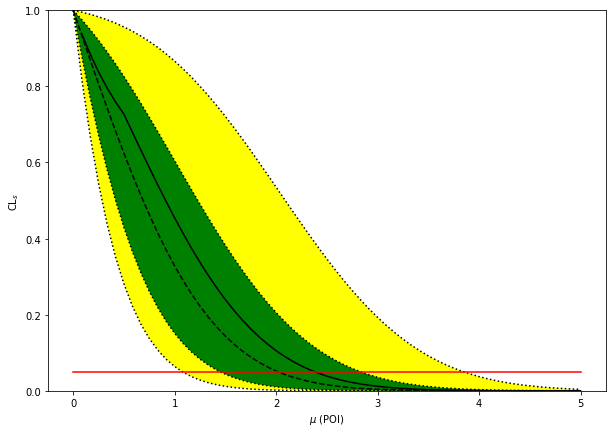

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
pyhf.contrib.viz.brazil.plot_results(ax, poi_tests, tests, test_size=0.05)
print(f'expected upper limits: {exp_limits}')
print(f'observed upper limit : {obs_limit}')

In [6]:
source = {
    "binning": [2, -0.5, 1.5],
    "bindata": {
        "data": [120.0, 145.0],
        "bkg": [100.0, 150.0],
        "bkgerr": [15.0, 20.0],
        "sig": [30.0, 45.0],
    },
}


my_observed_counts = source['bindata']['data']

model = hepdata_like(
    source['bindata']['sig'], source['bindata']['bkg'], source['bindata']['bkgerr']
)
data = my_observed_counts + model.config.auxdata


binning = source['binning']

nompars = model.config.suggested_init()


bonly_pars = [x for x in nompars]
bonly_pars[model.config.poi_index] = 0.0
nom_bonly = model.expected_data(bonly_pars, include_auxdata=False)

nom_sb = model.expected_data(nompars, include_auxdata=False)

init_pars = model.config.suggested_init()
par_bounds = model.config.suggested_bounds()

print(init_pars)

bestfit_pars = pyhf.infer.mle.fit(data, model, init_pars, par_bounds)
bestfit_cts = model.expected_data(bestfit_pars, include_auxdata=False)

[1.0, 1.0, 1.0]


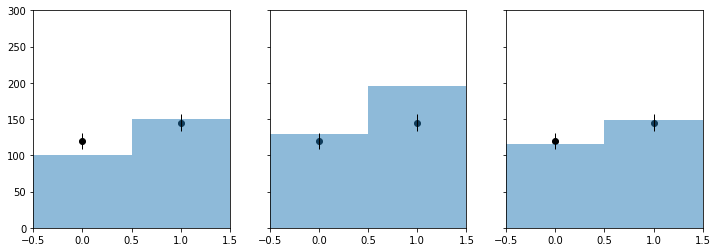

In [7]:
f, axarr = plt.subplots(1, 3, sharey=True)
f.set_size_inches(12, 4)

plot_histo(axarr[0], binning, nom_bonly)
plot_data(axarr[0], binning, my_observed_counts)
axarr[0].set_xlim(binning[1:])

plot_histo(axarr[1], binning, nom_sb)
plot_data(axarr[1], binning, my_observed_counts)
axarr[1].set_xlim(binning[1:])

plot_histo(axarr[2], binning, bestfit_cts)
plot_data(axarr[2], binning, my_observed_counts)
axarr[2].set_xlim(binning[1:])

plt.ylim(0, 300);

In [8]:
##  DUMMY 2D thing


def signal(m1, m2):
    massscale = 150.0
    minmass = 100.0
    countscale = 2000

    effective_mass = np.sqrt(m1 ** 2 + m2 ** 2)
    return [countscale * np.exp(-(effective_mass - minmass) / massscale), 0]


def CLs(m1, m2):
    signal_counts = signal(m1, m2)
    pdf = hepdata_like(
        signal_counts, source['bindata']['bkg'], source['bindata']['bkgerr']
    )
    try:
        cls_obs, cls_exp_set = pyhf.infer.hypotest(
            1.0, data, pdf, init_pars, par_bounds, return_expected_set=True
        )
        return cls_obs, cls_exp_set, True
    except AssertionError:
        print(f'fit failed for mass points ({m1}, {m2})')
        return None, None, False

In [9]:
nx, ny = 15, 15
grid = grid_x, grid_y = np.mgrid[
    100 : 1000 : complex(0, nx), 100 : 1000 : complex(0, ny)
]
X = grid.T.reshape(nx * ny, 2)
results = [CLs(m1, m2) for m1, m2 in X]

In [10]:
X = np.array([x for x, (_, _, success) in zip(X, results) if success])
yobs = np.array([obs for obs, exp, success in results if success]).flatten()
yexp = [
    np.array([exp[i] for obs, exp, success in results if success]).flatten()
    for i in range(5)
]

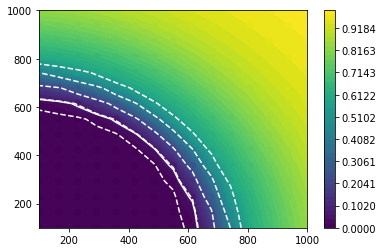

In [11]:
int_obs = griddata(X, yobs, (grid_x, grid_y), method='linear')

int_exp = [griddata(X, yexp[i], (grid_x, grid_y), method='linear') for i in range(5)]

plt.contourf(grid_x, grid_y, int_obs, levels=np.linspace(0, 1))
plt.colorbar()

plt.contour(grid_x, grid_y, int_obs, levels=[0.05], colors='w')
for level in int_exp:
    plt.contour(grid_x, grid_y, level, levels=[0.05], colors='w', linestyles='dashed')

plt.scatter(X[:, 0], X[:, 1], c=yobs, vmin=0, vmax=1);

In [12]:
sb.glue("number_2d_successpoints", len(X))